## Undersampling method comparison


In this section we explore several methods for handling the
data imbalance. We split our dataset as 70% training and
30% test. We perform 5-fold cross validation on the training
set to select the best parameters and report the results on
the test set. The results were obtained using python libraries
scikit-learn and imbalanced-learn.


- 精確度 precision 是指所有被模型預測為正確的樣本中，有多少是真正正確的
  - 當錯誤標記正確樣本的成本很高時，精確度很重要。例如在垃圾郵件篩選中，如果模型誤將重要郵件標記為垃圾郵件，可能會造成重大損失，所以需要高精確度。
- 召回率 recall 是指所有實際正確的樣本中，有多少被模型正確地識別出來。
  - 當漏掉正確樣本的成本很高時，召回率很重要。例如在癌症篩查中，如果模型漏掉真正的癌症病人，可能會造成嚴重後果，所以需要高召回率。

ps:
針對資料不平衡數據集，應該看 recall。在不平衡數據集中，少數類別的樣本較少，容易被忽視。如果你的目的是確保少數類別被正確識別出來，recall 是更合適的指標

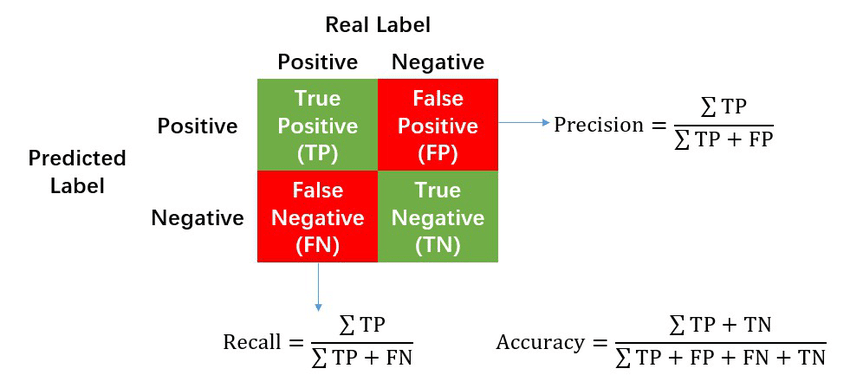


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc

# Parameters for the dataset
n_samples = 10000            # Total number of samples
n_classes = 2                # Number of classes
weights = [0.05, 0.95]       # Weights for the classes, indicating imbalance (5% of one class and 95% of the other)
class_sep = 1.2              # Separation between the classes
n_features = 10              # Total number of features
n_informative = 3            # Number of informative features (features that are useful for predicting the target)
n_redundant = 1              # Number of redundant features (linear combinations of the informative features)
n_clusters_per_class = 1     # Number of clusters per class

# Generate the dataset
X, y = make_classification(n_samples=n_samples, n_classes=n_classes, weights=weights, 
                           class_sep=class_sep, n_features=n_features, n_informative=n_informative, 
                           n_redundant=n_redundant, n_clusters_per_class=n_clusters_per_class, 
                           random_state=42)

# Create a DataFrame for better visualization
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['class'] = y

df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,class
0,-0.906262,0.893507,0.882136,1.009738,0.423372,1.483016,0.399302,-0.723201,-0.424083,-0.663385,1
1,-2.345331,1.577356,2.126555,-0.283252,2.288645,-0.493647,-1.418570,0.255304,1.230606,0.727549,1
2,-1.385938,-0.349938,0.582955,-2.175431,-0.640586,1.054359,2.076913,0.254051,0.226293,-0.442190,1
3,-2.046348,0.289273,-0.749696,0.471717,-0.086970,0.269887,1.668606,0.903550,-0.631238,-0.314659,1
4,-2.407067,-0.687817,-0.715962,-0.998456,-0.959146,0.055847,3.047559,-0.458319,2.847332,-0.322145,1


In [2]:
df["class"].value_counts()

class
1    9458
0     542
Name: count, dtype: int64

## Baseline

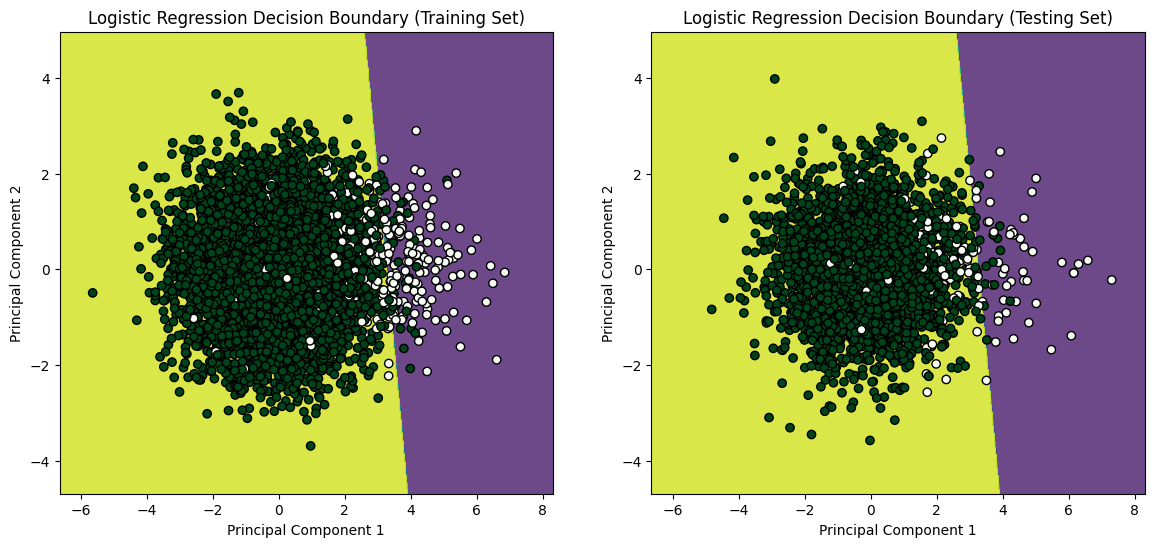

Cross-validation mean score: 0.9612857142857143
Cross-validation standard deviation: 0.0035685702847990867
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.73      0.28      0.41       162
     Class 1       0.96      0.99      0.98      2838

    accuracy                           0.96      3000
   macro avg       0.85      0.64      0.69      3000
weighted avg       0.95      0.96      0.95      3000



In [3]:



X = df.drop('class', axis=1)
y = df['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a logistic regression model on the PCA-transformed data with 5-fold cross-validation
log_reg_pca = LogisticRegression()
cross_val_scores_pca = cross_val_score(log_reg_pca, X_train_pca, y_train, cv=5)

# Fit the logistic regression model on PCA-transformed data
log_reg_pca.fit(X_train_pca, y_train)

# Predict the target values
y_pred = log_reg_pca.predict(X_test_pca)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])


# Function to plot the decision boundary using subplots
def plot_decision_boundary_subplot(X_train, y_train, X_test, y_test, model, cmap):
    h = .02  # step size in the mesh
    x_min, x_max = min(X_train[:, 0].min(), X_test[:, 0].min()) - 1, max(X_train[:, 0].max(), X_test[:, 0].max()) + 1
    y_min, y_max = min(X_train[:, 1].min(), X_test[:, 1].min()) - 1, max(X_train[:, 1].max(), X_test[:, 1].max()) + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Training set
    Z_train = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_train = Z_train.reshape(xx.shape)
    ax[0].contourf(xx, yy, Z_train, alpha=0.8)
    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='black', marker='o',cmap=cmap)
    ax[0].set_title('Logistic Regression Decision Boundary (Training Set)')
    ax[0].set_xlabel('Principal Component 1')
    ax[0].set_ylabel('Principal Component 2')

    # Testing set
    Z_test = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_test = Z_test.reshape(xx.shape)
    ax[1].contourf(xx, yy, Z_test, alpha=0.8)
    ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='black', marker='o',cmap=cmap)
    ax[1].set_title('Logistic Regression Decision Boundary (Testing Set)')
    ax[1].set_xlabel('Principal Component 1')
    ax[1].set_ylabel('Principal Component 2')

    plt.show()

# Plot decision boundaries for training and testing sets with PCA-transformed data
plot_decision_boundary_subplot(X_train_pca, y_train, X_test_pca, y_test, log_reg_pca, plt.cm.Greens)

# Output cross-validation scores for PCA-transformed data
print("Cross-validation mean score:", cross_val_scores_pca.mean())
print("Cross-validation standard deviation:", cross_val_scores_pca.std())

# Output classification report for the test set
print("Classification Report:\n", classification_rep)


## Weighted loss function

One technique for handling class imbalance, is to use a
weighted loss function. In order to boost performance on the
minority class, the penalty for misclassifying minority class
examples can be increased.

In scikit-learn, this can be done for supported classifiers
using the ’class weight’ parameter. Setting this parameter
to ’balanced’, weights inversely proportional to the class sizes
are used to multiply the loss function.

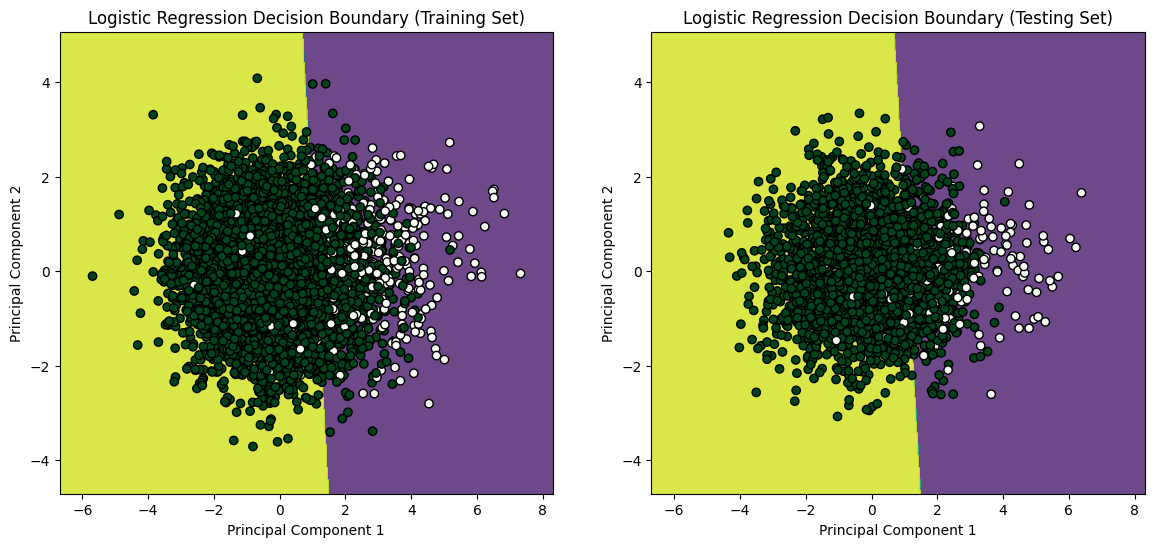

Cross-validation mean score: 0.8305714285714286
Cross-validation standard deviation: 0.005613395058396712
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.20      0.80      0.32       160
     Class 1       0.99      0.82      0.90      2840

    accuracy                           0.82      3000
   macro avg       0.59      0.81      0.61      3000
weighted avg       0.94      0.82      0.87      3000



In [4]:
# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)    # Reduce to 2 principal components for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a logistic regression model on the PCA-transformed data with 5-fold cross-validation
# Using class_weight='balanced' to handle class imbalance
log_reg_pca = LogisticRegression(class_weight='balanced')
cross_val_scores_pca = cross_val_score(log_reg_pca, X_train_pca, y_train, cv=5)

# Fit the logistic regression model on PCA-transformed data
log_reg_pca.fit(X_train_pca, y_train)

# Predict the target values
y_pred = log_reg_pca.predict(X_test_pca)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])


# Plot decision boundaries for training and testing sets with PCA-transformed data using the 'Greens' colormap
plot_decision_boundary_subplot(X_train_pca, y_train, X_test_pca, y_test, log_reg_pca, plt.cm.Greens)

# Output cross-validation scores for PCA-transformed data
print("Cross-validation mean score:", cross_val_scores_pca.mean())
print("Cross-validation standard deviation:", cross_val_scores_pca.std())

# Output classification report for the test set
print("Classification Report:\n", classification_rep)

# UnderSampling

----

## Random undersampling of majority class

A simple undersampling technique is uniformly random
undersampling of the majority class. This can potentially
lead to loss of information about the majority class. However, in cases where each example of the majority class is
near other examples of the same class, this method might
yield good results.

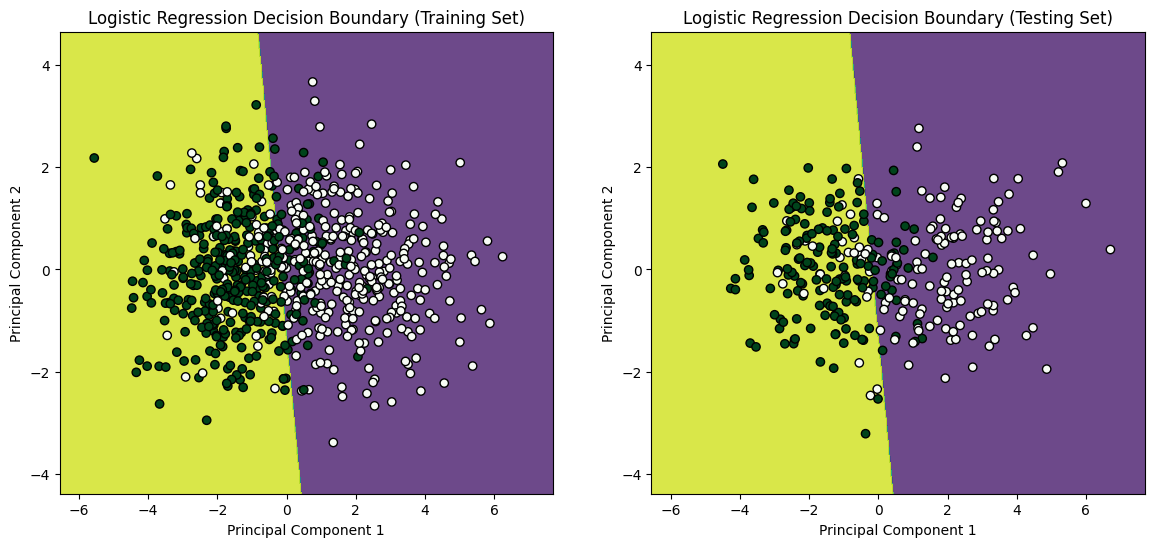

Cross-validation mean score: 0.8245381666085745
Cross-validation standard deviation: 0.024526742509443724
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.79      0.80       155
     Class 1       0.81      0.82      0.82       171

    accuracy                           0.81       326
   macro avg       0.81      0.81      0.81       326
weighted avg       0.81      0.81      0.81       326



In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=66)

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a logistic regression model on the PCA-transformed data with 5-fold cross-validation
log_reg_pca = LogisticRegression()

# Fit the logistic regression model on PCA-transformed data
log_reg_pca.fit(X_train_pca, y_train)

# Predict the target values
y_pred = log_reg_pca.predict(X_test_pca)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])


cross_val_scores_pca = cross_val_score(log_reg_pca, X_train_pca, y_train, cv=5)

# Fit the logistic regression model on PCA-transformed data
log_reg_pca.fit(X_train_pca, y_train)

# Plot decision boundaries for training and testing sets with PCA-transformed data
plot_decision_boundary_subplot(X_train_pca, y_train, X_test_pca, y_test, log_reg_pca, plt.cm.Greens)

# Output cross-validation scores for PCA-transformed data
print("Cross-validation mean score:", cross_val_scores_pca.mean())
print("Cross-validation standard deviation:", cross_val_scores_pca.std())

# Output classification report for the test set
print("Classification Report:\n", classification_rep)


## NearMiss v1.0

To implement the NearMiss-1 undersampling technique, we can use the NearMiss method from the imblearn library. NearMiss-1 selects the majority class samples that are closest to the minority class samples.

In NearMiss-1, those points from majority are retained whose
mean distance to the k nearest points in minority is lowest, where
k is a tunable hyperparameter.


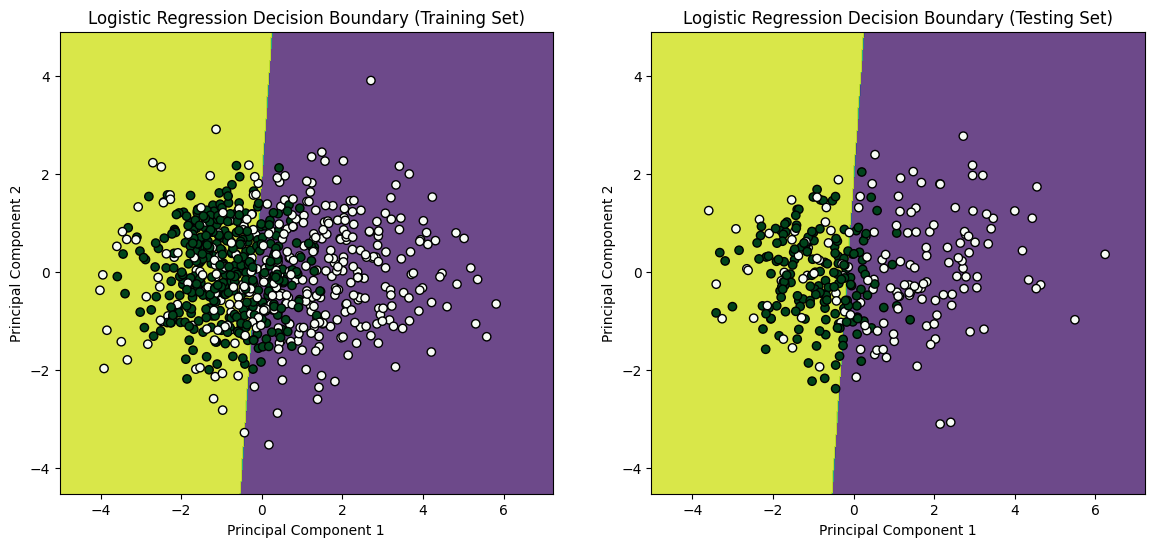

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.74      0.74      0.74       155
     Class 1       0.76      0.77      0.76       171

    accuracy                           0.75       326
   macro avg       0.75      0.75      0.75       326
weighted avg       0.75      0.75      0.75       326



In [6]:
from imblearn.under_sampling import NearMiss

# Apply NearMiss-1 undersampling
nearmiss = NearMiss(version=1, n_neighbors=2)
X_res, y_res = nearmiss.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=66)

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a logistic regression model on the PCA-transformed data with 5-fold cross-validation
log_reg_pca = LogisticRegression()
cross_val_scores_pca = cross_val_score(log_reg_pca, X_train_pca, y_train, cv=5)

# Fit the logistic regression model on PCA-transformed data
log_reg_pca.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = log_reg_pca.predict(X_test_pca)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])


# Plot decision boundaries for training and testing sets with PCA-transformed data
plot_decision_boundary_subplot(X_train_pca, y_train, X_test_pca, y_test, log_reg_pca, plt.cm.Greens)

# Output classification report for the test set
print("Classification Report:\n", classification_rep)

## NearMiss v2.0
This version of NearMiss retains those majority class samples whose mean distance to the k farthest minority class samples is the lowest. It focuses on ensuring that the retained majority class samples are closer to the farthest minority class samples, potentially creating a more challenging decision boundary.

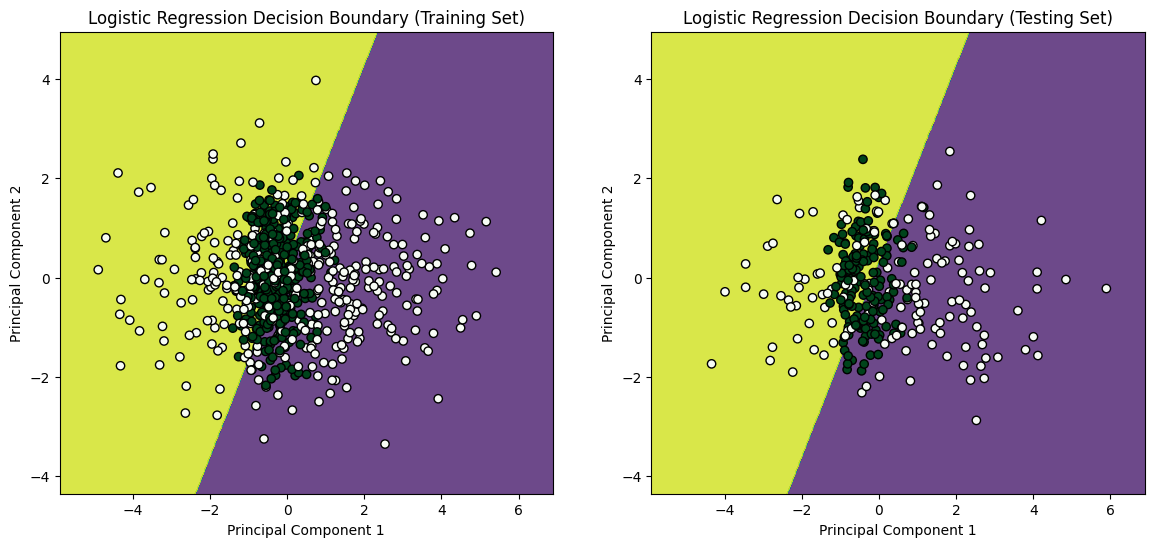

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.58      0.61      0.60       155
     Class 1       0.63      0.60      0.62       171

    accuracy                           0.61       326
   macro avg       0.61      0.61      0.61       326
weighted avg       0.61      0.61      0.61       326



In [7]:
# Apply NearMiss-2 undersampling
nearmiss = NearMiss(version=2, n_neighbors=2)
X_res, y_res = nearmiss.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=66)

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a logistic regression model on the PCA-transformed data with 5-fold cross-validation
log_reg_pca = LogisticRegression()
cross_val_scores_pca = cross_val_score(log_reg_pca, X_train_pca, y_train, cv=5)

# Fit the logistic regression model on PCA-transformed data
log_reg_pca.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = log_reg_pca.predict(X_test_pca)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# Plot decision boundaries for training and testing sets with PCA-transformed data
plot_decision_boundary_subplot(X_train_pca, y_train, X_test_pca, y_test, log_reg_pca, plt.cm.Greens)

# Output classification report for the test set
print("Classification Report:\n", classification_rep)

## NearMiss v3.0

NearMiss-3 selects k nearest neighbors in majority for every point in minority. In this case, the
undersampling ratio is directly controlled by k and is not
separately tuned.


 This variant of NearMiss selects the k nearest neighbors in the majority class for every point in the minority class. The undersampling ratio is directly controlled by the parameter k and is not separately tuned.


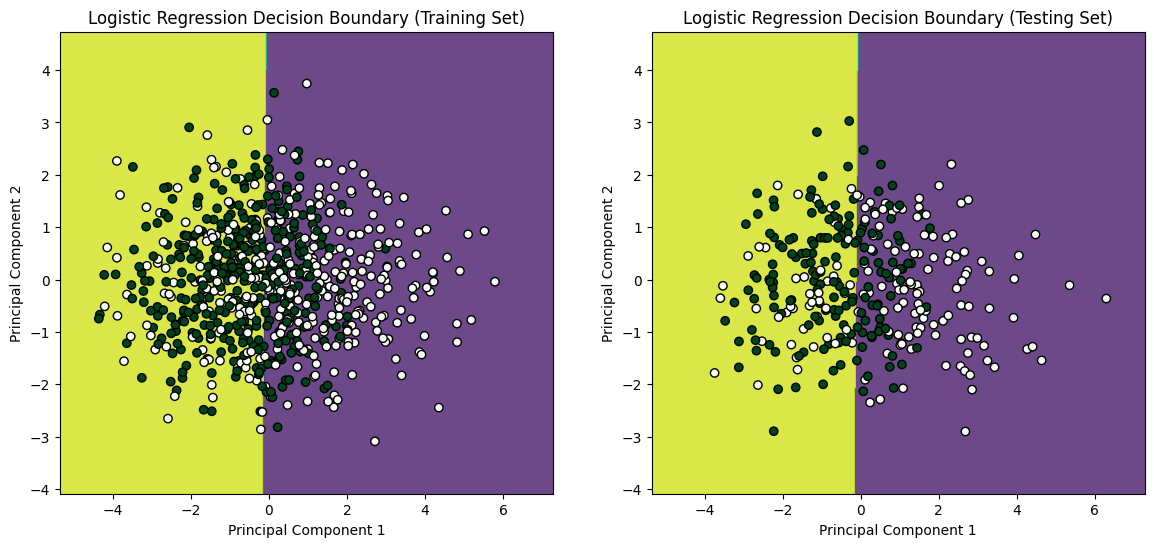

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.65      0.71      0.68       155
     Class 1       0.71      0.65      0.68       171

    accuracy                           0.68       326
   macro avg       0.68      0.68      0.68       326
weighted avg       0.68      0.68      0.68       326



In [8]:
# Apply NearMiss-3 undersampling
nearmiss = NearMiss(version=3, n_neighbors=2)
X_res, y_res = nearmiss.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=66)

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a logistic regression model on the PCA-transformed data with 5-fold cross-validation
log_reg_pca = LogisticRegression()
cross_val_scores_pca = cross_val_score(log_reg_pca, X_train_pca, y_train, cv=5)

# Fit the logistic regression model on PCA-transformed data
log_reg_pca.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = log_reg_pca.predict(X_test_pca)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# Plot decision boundaries for training and testing sets with PCA-transformed data
plot_decision_boundary_subplot(X_train_pca, y_train, X_test_pca, y_test, log_reg_pca, plt.cm.Greens)

# Output classification report for the test set
print("Classification Report:\n", classification_rep)

## Condensed Nearest Neighbor (CNN)


In CNN undersampling, the goal is to choose a subset
U of the training set T such that for every point in T its
nearest neighbor in U is of the same class. 

Undersampling via CNN can be slower compared to other
methods since it requires many passes over the training data.
Further, because of the randomness involved in the selection
of points at each iteration, the subset selected can vary significantly.

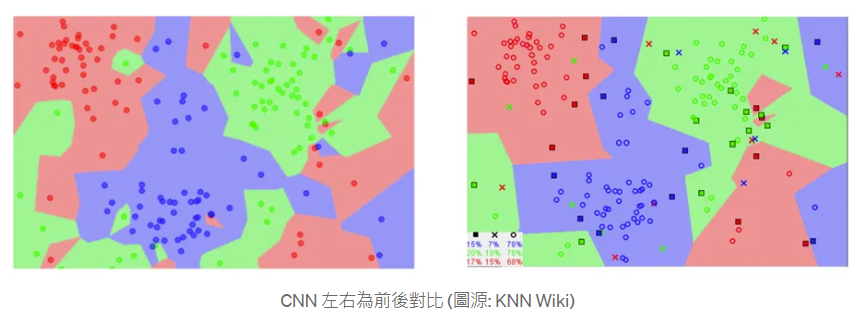

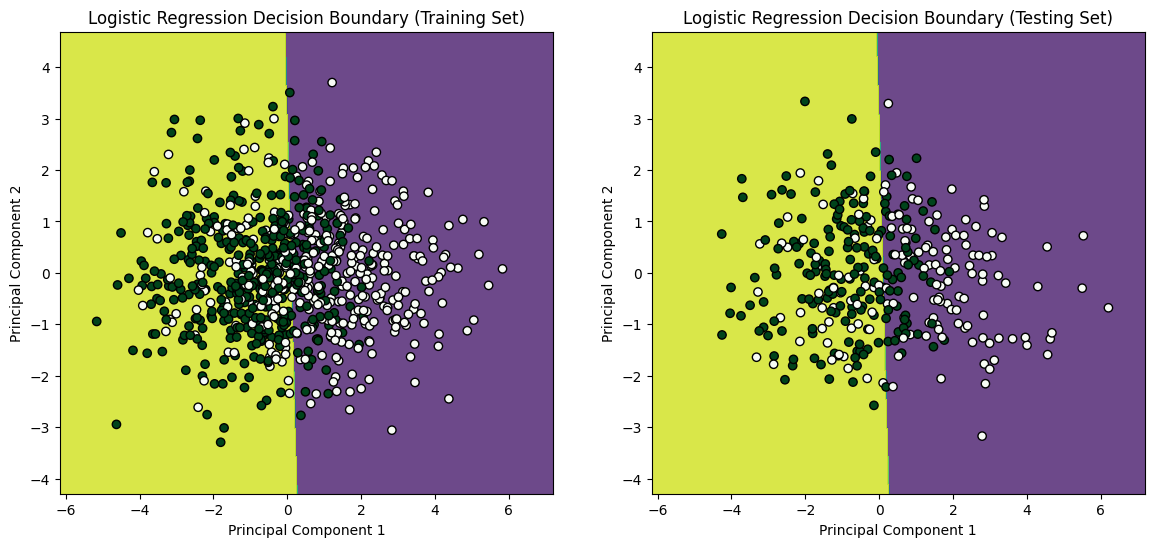

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.67      0.68      0.68       155
     Class 1       0.73      0.73      0.73       189

    accuracy                           0.71       344
   macro avg       0.70      0.70      0.70       344
weighted avg       0.71      0.71      0.71       344



In [9]:
from imblearn.under_sampling import CondensedNearestNeighbour

# Apply CNN undersampling
cnn = CondensedNearestNeighbour(n_neighbors=3)
X_res, y_res = cnn.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=66)

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a logistic regression model on the PCA-transformed data with 5-fold cross-validation
log_reg_pca = LogisticRegression()
cross_val_scores_pca = cross_val_score(log_reg_pca, X_train_pca, y_train, cv=5)

# Fit the logistic regression model on PCA-transformed data
log_reg_pca.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = log_reg_pca.predict(X_test_pca)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# Plot decision boundaries for training and testing sets with PCA-transformed data
plot_decision_boundary_subplot(X_train_pca, y_train, X_test_pca, y_test, log_reg_pca, plt.cm.Greens)

# Output classification report for the test set
print("Classification Report:\n", classification_rep)


## Edited Nearest Neighbor (ENN)
The ENN algorithm removes samples from the majority class whose class label differs from the majority of its k nearest neighbors. This helps to clean the data by removing potentially noisy samples.

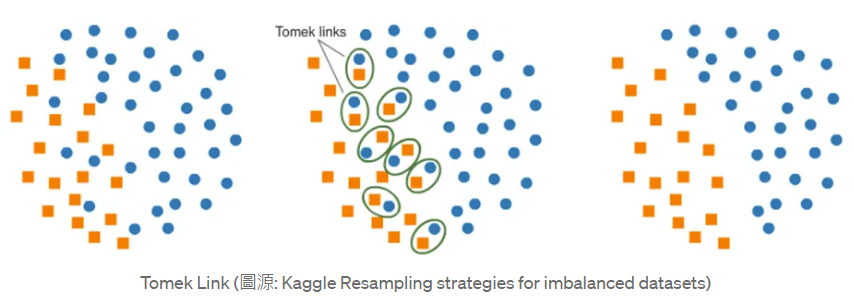

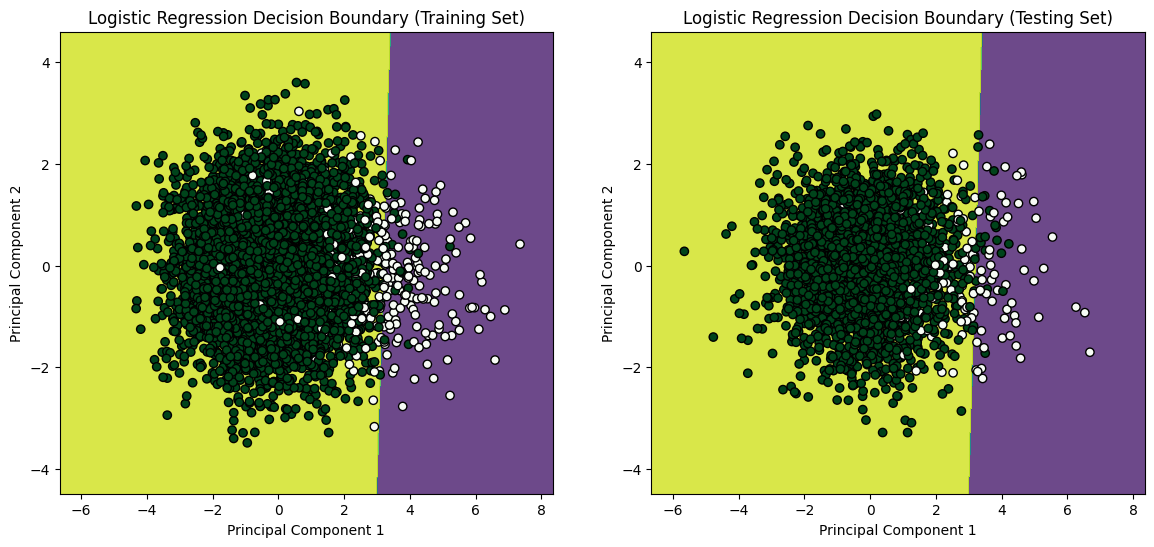

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.74      0.32      0.45       169
     Class 1       0.96      0.99      0.98      2749

    accuracy                           0.95      2918
   macro avg       0.85      0.66      0.71      2918
weighted avg       0.95      0.95      0.95      2918



In [10]:
from imblearn.under_sampling import EditedNearestNeighbours


# Apply ENN undersampling
enn = EditedNearestNeighbours(n_neighbors=3)  # Using 3 nearest neighbors
X_res, y_res = enn.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=66)

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a logistic regression model on the PCA-transformed data with 5-fold cross-validation
log_reg_pca = LogisticRegression()
cross_val_scores_pca = cross_val_score(log_reg_pca, X_train_pca, y_train, cv=5)

# Fit the logistic regression model on PCA-transformed data
log_reg_pca.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = log_reg_pca.predict(X_test_pca)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# Plot decision boundaries for training and testing sets with PCA-transformed data
plot_decision_boundary_subplot(X_train_pca, y_train, X_test_pca, y_test, log_reg_pca, plt.cm.Greens)

# Output classification report for the test set
print("Classification Report:\n", classification_rep)
